# MACHINE LERNING FOR DRAWINGS CLASSIFICATION


### IMPLEMENTATION OF T-SNE AND RANDOM FOREST FOR MULTICLASS CLASSIFICATION

First we import all libraries we will need along the project

In [ ]:
import urllib.request
import os 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import pandas as pd
import errno
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns

%matplotlib inline

We used a function found at a [Github repository](https://github.com/zaidalyafeai/QuickDraw10/blob/master/quick_draw10.py) and made by user [Zaid Alyafeai](https://github.com/zaidalyafeai) that downloaded the dataset to our computer and then laods it to the notebook.

In [ ]:
def download_and_load(test_split = 0.2, max_items_per_class = 10000):
    root = 'data'
    try:
        os.mkdir(root)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass   
    print('downloading ...')
    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in class_names:
        path = base+c+'.npy'
        print(path)
        urllib.request.urlretrieve(path, f'{root}/{c}.npy')
    print('loading ...')
  
    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    
    #load each data file 
    for idx, file in enumerate(class_names):
        data = np.load(f'{root}/{file}.npy')
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

    data = None
    labels = None

    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #reshape and inverse the colors 
    x = 255 - np.reshape(x, (x.shape[0], 28, 28))

    #separate into training and testing 
    test_size  = int(x.shape[0]/100*(test_split*100))

    x_test = x[0:test_size, :]
    y_test = y[0:test_size]

    x_train = x[test_size:x.shape[0], :]
    y_train = y[test_size:y.shape[0]]
  
    print('Training Data : ', x_train.shape[0])
    print('Testing  Data : ', x_test.shape[0])
    return x_train, y_train, x_test, y_test, class_names

At this part we can select what will be the words that our model will have to classify. The options in the are indicated in the following link https://github.com/googlecreativelab/quickdraw-dataset/blob/master/categories.txt

Notice that you can select as many as you want, but the more you choose, the higher the computational cost.

In [ ]:
class_names = ['cloud','sun', 'umbrella', 'eyeglasses']
#,'pants',,'table','ladder','eyeglasses','clock','scissors','cup'] 

# Download and load the selected categories and building the dataframes:

Select number of items per class on the first line:

In [ ]:
x_train, y_train, x_test, y_test, class_names = download_and_load(max_items_per_class = 10000)

x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
data = []
for label in range(0, len(class_names)):
    for img in  x[y == label]:
        img = img.astype(int)
        for i in range(0, len(img)):
            for j in range(0, len(img[i])):
                if (img[i][j] > 127):
                    img[i][j] = 0
                else:
                    img[i][j] = 1
        data.append([class_names[label]]+img.flatten().tolist())
column_names = ["label"]
for i in range(0, 784):
    column_names.append(str(i))
df = pd.DataFrame(data, columns=column_names) 
df = dataset.sample(frac=1).reset_index(drop=True)
df.head()

downloading ...
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/umbrella.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
loading ...
Training Data :  32000
Testing  Data :  8000


,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,sun,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,cloud,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,cloud,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,umbrella,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,cloud,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(dataset)

40000

# Apply the t-SNE function for visualization:

In [ ]:
pixel_values = df.drop(columns=['label'])
targets = df['label']

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)   # reducing the n_columns to 2
transformed_data = tsne.fit_transform(pixel_values.iloc[:10000, :])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
tsne_df = pd.DataFrame(np.column_stack((transformed_data, targets[:10000])),
                        columns=["X", "y", "targets"])

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'CLustered data after t-SNE transformation')

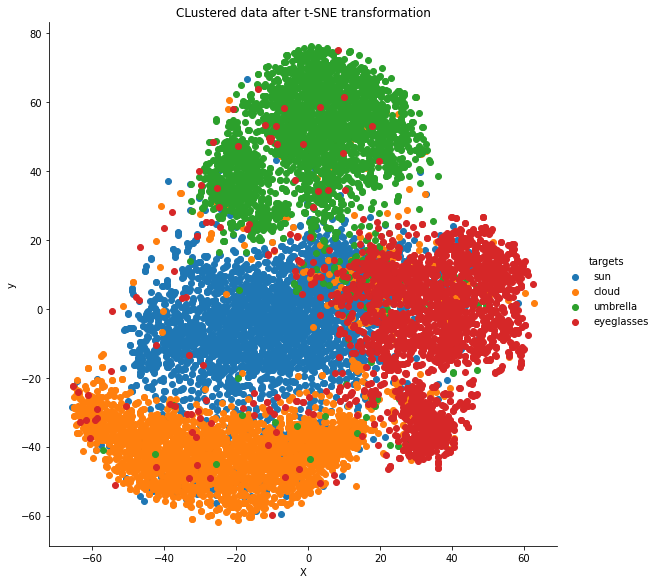

In [ ]:
import matplotlib.pyplot as plt
grid = sns.FacetGrid(tsne_df, hue="targets", size=8)
grid.map(plt.scatter, "X", "y").add_legend()
plt.title("CLustered data after t-SNE transformation")


# Use Random Forest for classification:

In [ ]:
X = tsne_df.drop('targets', axis=1)
y = tsne_df['targets']
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=20)  #Splitting into training and validation set

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators=6)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=6)

In [ ]:
pred = rfc.predict(X_val)
print(f'The accuracy on validation set is {accuracy_score(y_val, pred)}')

The accuracy on validation set is 0.8972
